In [1]:
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
import pandas as pd
import random

In [2]:
df = pd.read_csv('data/em_data.txt', delim_whitespace=True, header=None)
# to numpy
data = df.values.flatten()
print(type(data), data.shape)

<class 'numpy.ndarray'> (1000,)


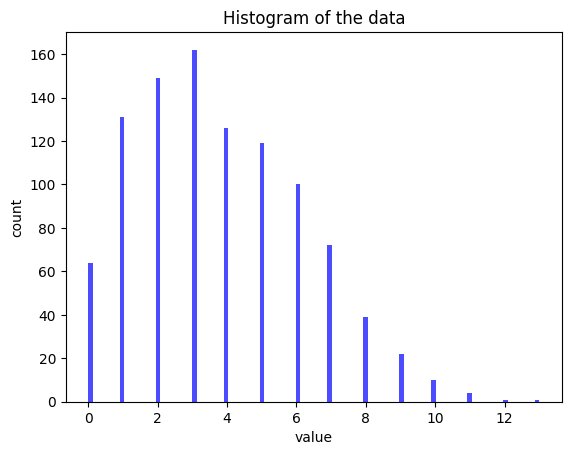

In [3]:
fig, ax = plt.subplots()
ax.hist(data, bins=100, color='blue', alpha=0.7)
ax.set_xlabel('value')
ax.set_ylabel('count')
ax.set_title('Histogram of the data')
plt.show()

In [4]:
class PoissonMixtureModel:
    def __init__(self, num_components=2, tolerance=1e-6, max_iterations=1000):
        self.num_components = num_components
        self.tolerance = tolerance
        self.max_iterations = max_iterations
        self.weights = None
        self.lambdas = None
        self.log_likelihoods = []

    def initialize_parameters(self, data):

        self.lambdas = [random.uniform(0, 5) for _ in range(self.num_components)]
        self.weights = np.array([1 / self.num_components] * self.num_components)  # Uniform initial weights
    
    def e_step(self, data):
        """
        E-step: Calculate responsibilities (posterior probabilities) for each data point and component.
        """
        poisson_pmf = poisson.pmf(data[:, None], self.lambdas)  # (n, m) matrix, n data points, m lambdas
        weighted_pmf = self.weights * poisson_pmf  # (n, m)
        responsibilities = weighted_pmf / weighted_pmf.sum(axis=1, keepdims=True)
        return responsibilities
    
    def m_step(self, data, responsibilities):
        """
        M-step: Update the weights and lambdas using the current responsibilities.
        """
        n = len(data)
        self.weights = responsibilities.sum(axis=0) / n
        weighted_data_sum = np.dot(responsibilities.T, data)  # (m, ) vector, m lambdas
        self.lambdas = weighted_data_sum / responsibilities.sum(axis=0)
    
    def compute_log_likelihood(self, data):
        """
        Compute the log likelihood of the data given the current model parameters (weights and lambdas).
        """
        poisson_pmf = poisson.pmf(data[:, None], self.lambdas)  # (n, m) matrix, n data points, m lambdas
        weighted_pmf = self.weights * poisson_pmf  # (n, m)
        log_likelihood = np.sum(np.log(np.sum(weighted_pmf, axis=1)))  # Sum log of weighted PMFs
        return log_likelihood

    def fit(self, data):
        """
        Fit the Poisson Mixture Model using the EM algorithm.
        """
        self.initialize_parameters(data)
        log_likelihood = -np.inf

        for iteration in range(self.max_iterations):
            # E-step
            responsibilities = self.e_step(data)

            # M-step
            self.m_step(data, responsibilities)

            new_log_likelihood = self.compute_log_likelihood(data)

            if abs(new_log_likelihood - log_likelihood) < self.tolerance:
                break

            log_likelihood = new_log_likelihood
            self.log_likelihoods.append(log_likelihood)
            
            # print(f"Iteration {iteration + 1}, Log Likelihood: {log_likelihood}")

        return self.weights, self.lambdas, self.log_likelihoods
    
    def predict(self, data):
        """
        Predict the most likely component for each data point.
        """
        poisson_pmf = poisson.pmf(data[:, None], self.lambdas)
        weighted_pmf = self.weights * poisson_pmf
        return np.argmax(weighted_pmf, axis=1)
    
    def plot_log_likelihood(self):
        plt.plot(self.log_likelihoods)
        plt.xlabel('Iteration')
        plt.ylabel('Log Likelihood')
        plt.title('Log Likelihood vs. Iteration')
        plt.show()

    def plot_means(self,labels):
        plt.hist(data, bins=100, color='blue', alpha=0.7)
        plt.xlabel('Value')
        plt.ylabel('Count')
        plt.title('Histogram of the Data')
        for i, mean in enumerate(self.lambdas):
            plt.axvline(mean, color='red', linestyle='dashed', linewidth=1)
            plt.text(mean+0.2, 80, labels[i], rotation=90)

        plt.show() 

    def plot_proportions(self,labels):
        plt.pie(self.weights, labels=labels, autopct='%1.1f%%')
        plt.title('Proportion of Each Component')
        plt.show()
    
pmm = PoissonMixtureModel(num_components=2)

weights, lambdas, log_likelihoods = pmm.fit(data)
lambdas = lambdas[::-1]
weights = weights[::-1]
mean_1 , mean_2 = lambdas
proportion_1, proportion_2 = weights
print("Estimated Parameters:")
print(f"Mean number of children (with family planning): {mean_1}")
print(f"Mean number of children (without family planning): {mean_2}")
print(f"Proportion of families with family planning: {proportion_1}")
print(f"Proportion of families without family planning: {proportion_2}")

Estimated Parameters:
Mean number of children (with family planning): 4.911267749525195
Mean number of children (without family planning): 1.7830551814445332
Proportion of families with family planning: 0.6438005009970074
Proportion of families without family planning: 0.35619949900299236


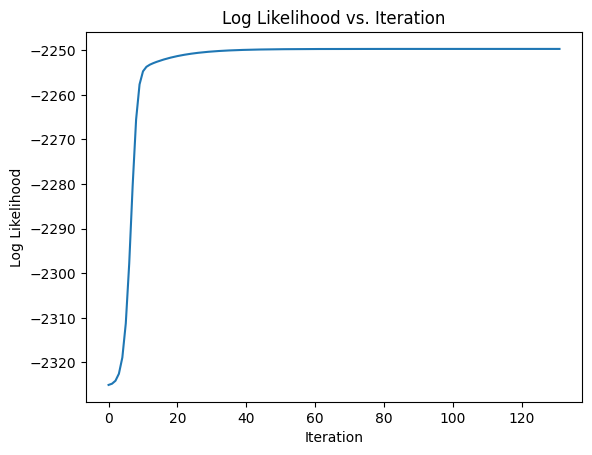

In [ ]:

pmm.plot_log_likelihood()

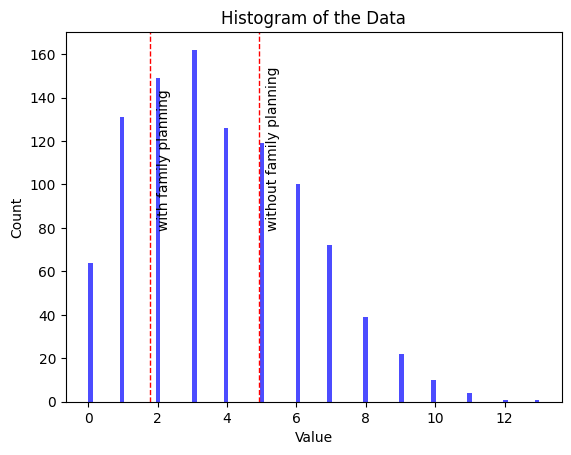

In [6]:
pmm.plot_means([ "with family planning","without family planning"])

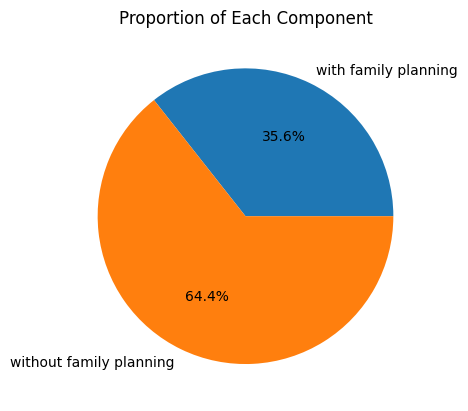

In [7]:
pmm.plot_proportions(["with family planning","without family planning"])